# Домашняя работа

Найти данные о заболеваемости/смертности/выздоровлении COVID-19 (они есть например на Kaggle) и использовать их для решения заданий. Можно использовать как данные по какому-то конкретному региону/стране, так и данные по всему миру.

Скорее всего, результат по всем задачам получится не очень.

## Easy

Проверить ряд на стационарность. Привести ряд к стационарному виду.

Построить прогноз заболеваемости, используя модель ARIMA, на месяц вперед. Подобрать оптимальные параметры модели. Визуализировать результат. Выглядит ли такой прогноз реалистичным? 

Для решения задачи можно использовать `pmdarima`

## Normal

Применить градиентный бустинг для решения задачи. Используя кросс-валидацию, сравнить результаты ARIMA и бустинга.

## Hard

Применить библиотеку Prophet, сравнить результаты с предыдущими двумя.

Сравнить результат с бейзлайн-решением (прогноз на завтра - сегодняшнее количество).

Сравнить результат со сглаживанием и без.

Оценить остатки всех трех моделей, проверить гипотезу, что остатки распределены нормально.

### Загрузка данных по коронавирусу

Загрузим даные по коронавирусу из https://cloud.yandex.ru/services/datalens. Сохраним их в csv и загрузим в pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cw19 = pd.read_csv('covid19_world.csv', sep=';')
cw19.head(5)

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день
0,Гамбия,18.01.2021,3933,3697.0,128,23,5.0,1
1,Финляндия,17.04.2021,83633,46000.0,887,0,0.0,0
2,Судан,03.08.2020,11738,6137.0,752,0,0.0,0
3,Камерун,15.09.2020,20271,18837.0,415,43,0.0,0
4,Косово и Метохия,04.01.2021,51965,42637.0,1344,0,0.0,0


Выберем данные относящиеся к России. Данные неотсортированы по дате. Поэтому выполним сортировку по дате.

In [3]:
rus = cw19[cw19['Страна'] == 'Россия']
rus['Дата'] = pd.to_datetime(rus['Дата'], format="%d.%m.%Y")
rus = rus.sort_values('Дата')
rus

<ipython-input-3-84c25d359c56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rus['Дата'] = pd.to_datetime(rus['Дата'], format="%d.%m.%Y")


,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день
49066,Россия,2020-06-29,640246,402778.0,9152,6683,4342.0,92
45312,Россия,2020-06-30,646929,411973.0,9306,6683,9195.0,154
63102,Россия,2020-07-01,653479,422235.0,9521,6550,10262.0,215
67083,Россия,2020-07-02,660231,428276.0,9668,6752,6041.0,147
60213,Россия,2020-07-03,666941,437155.0,9844,6710,8879.0,176
...,...,...,...,...,...,...,...,...
20659,Россия,2021-06-24,5325940,4858571.0,129278,19871,13258.0,559
24951,Россия,2021-06-25,5346005,4872411.0,129869,20065,13840.0,591
6683,Россия,2021-06-26,5367317,4886550.0,130479,21312,14139.0,610
3189,Россия,2021-06-27,5387486,4899158.0,131070,20169,12608.0,591


Нас будет интересовать статистика за день. Обрежем таблицу и отобразим динамику по трем основным категориям на графике.

In [4]:
rusd = rus.iloc[:,1:2].join(rus.iloc[:,5:8])
rusd

,Дата,Заражений за день,Выздоровлений за день,Смертей за день
49066,2020-06-29,6683,4342.0,92
45312,2020-06-30,6683,9195.0,154
63102,2020-07-01,6550,10262.0,215
67083,2020-07-02,6752,6041.0,147
60213,2020-07-03,6710,8879.0,176
...,...,...,...,...
20659,2021-06-24,19871,13258.0,559
24951,2021-06-25,20065,13840.0,591
6683,2021-06-26,21312,14139.0,610
3189,2021-06-27,20169,12608.0,591


In [5]:
def plotCovid(frame):
    x = range(0, len(frame))
    fig, ax1 = plt.subplots()
    fig.set_size_inches(14, 8)
    ax2 = ax1.twinx()
    ax1.set_ylabel('Заражения/выздоровления')
    ax2.set_ylabel('Смертей за день')
    clr = ['none', 'blue', 'green']
    for i in range(1, 3):
        col_name = frame.columns[i]
        ax1.plot(x, frame[col_name], color=clr[i])
    ax1.legend(labels = [frame.columns[1], frame.columns[2]])
    ax2.plot(x, frame[frame.columns[3]], color='red')

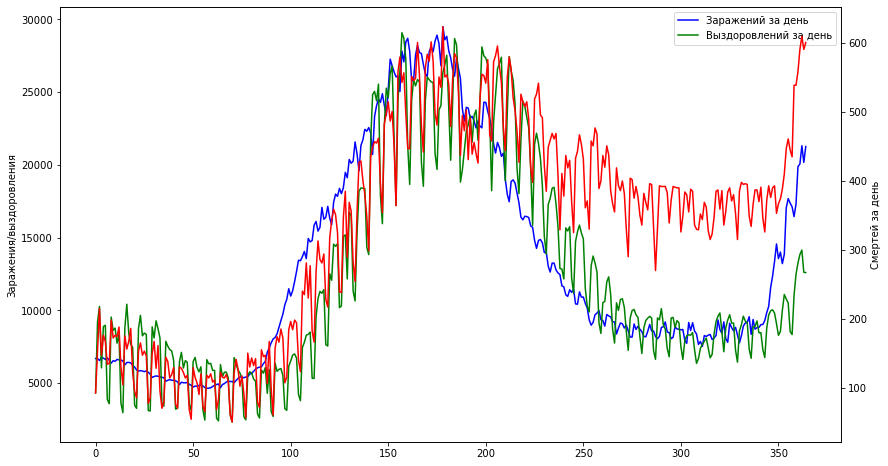

In [6]:
plotCovid(rusd)

Оценим стационарность данных. Напишем функцию, выполняющую тесты KPSS и Дики - Фуллера для каждой из колонок

In [7]:
import statsmodels.tsa.stattools
import warnings
warnings.filterwarnings("ignore")

In [8]:
def test_stat(frame, t_test = 'adfuller'):
    df_test = {}
    for i in range(1, 4):
        if t_test == 'adfuller':
            stat, pvalue, *_ = statsmodels.tsa.stattools.adfuller(frame.iloc[:, i])
            df_test[rusd.columns[i]] = pvalue
        elif t_test == 'kpss':
            stat, pvalue, *_ = statsmodels.tsa.stattools.kpss(frame.iloc[:, i])
            df_test[rusd.columns[i]] = pvalue
    return df_test

In [9]:
df_test = test_stat(rusd, 'adfuller')
df_test

{'Заражений за день': 0.2266449031506424,
 'Выздоровлений за день': 0.3757457898668318,
 'Смертей за день': 0.8416532497311824}

Нулевая гипотеза теста Дика-Фуллера отрицает стационарность ряда. PValue для каждой из колонок значим и превышает критический уровень 0.05. Следовательно все три фактора не стационарны.

Выполним KPSS тест (критерий Kwiatkowski–Phillips–Schmidt–Shin) стационарности для этиж же данных:

In [10]:
kpss_test = test_stat(rusd, 'kpss')
kpss_test

{'Заражений за день': 0.07309859004655941,
 'Выздоровлений за день': 0.04984388411612647,
 'Смертей за день': 0.01}

Нулевая гипотеза теста KPSS подтверждает стационарность данных. Согласно этому тесту P-Value только у первой колонки "Заражений за день" выше критического значения 0.05. Следовательно эту колонку можно признать стационарной, однако другие нет.

**Будем считать, что данные по всем трем видам статистики заболеваемости _нестационарны_.**

Приведем все три колонки данных к стационарному виду с помощью логарифмирования. Для этого напишим функцию выполняющую логарифмирование и диференцирование

In [11]:
def toStat(frame, t_stat='log'):
    dflog = pd.DataFrame(frame.iloc[0:,0])
    if(t_stat == 'log'):
        for i in range(1, 4):
            dflog[frame.columns[i] + ' log'] = np.log(frame.iloc[:, i])
    elif t_stat == 'diff':
        for i in range(1, 4):
            dflog[frame.columns[i] + ' diff'] = frame.iloc[:, i].diff(1)
    dflog = dflog.fillna(0)
    return dflog

In [12]:
drusd = rusd.diff(1)
drusd = drusd.dropna()
#dflog = toStat(rusd, t_stat='log')
#dflog

Снова проверим на стационарность:

In [13]:
df_test = test_stat(drusd, 'kpss')
df_test

{'Заражений за день': 0.1,
 'Выздоровлений за день': 0.1,
 'Смертей за день': 0.1}

К сожалению логарифмирование не помогло. Ряды по-прежнему остались не стационарными.

Выполним диференцирование рядов. Это более надежный способ.

In [14]:
dflog = toStat(rusd, t_stat='diff')
dflog

,Дата,Заражений за день diff,Выздоровлений за день diff,Смертей за день diff
49066,2020-06-29,0.0,0.0,0.0
45312,2020-06-30,0.0,4853.0,62.0
63102,2020-07-01,-133.0,1067.0,61.0
67083,2020-07-02,202.0,-4221.0,-68.0
60213,2020-07-03,-42.0,2838.0,29.0
...,...,...,...,...
20659,2021-06-24,2568.0,783.0,20.0
24951,2021-06-25,194.0,582.0,32.0
6683,2021-06-26,1247.0,299.0,19.0
3189,2021-06-27,-1143.0,-1531.0,-19.0


Снова проверим на стационарность

In [15]:
kpss_test = test_stat(dflog, 'kpss')
kpss_test

{'Заражений за день': 0.1,
 'Выздоровлений за день': 0.1,
 'Смертей за день': 0.1}

Выведим график получившейся после диференцирования

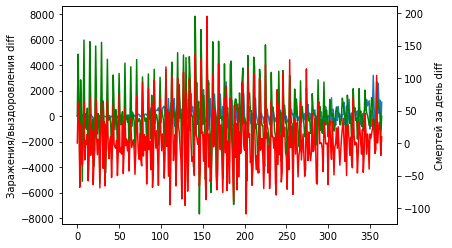

In [16]:
x = range(0, len(dflog))
fig, ax1 = plt.subplots()
ax1.set_ylabel('Заражения/выздоровления diff')
ax1.plot(x, dflog['Заражений за день diff'])
ax1.plot(x, dflog['Выздоровлений за день diff'], color='green')
ax2 = ax1.twinx()
ax2.set_ylabel('Смертей за день diff')
ax2.plot(x, dflog['Смертей за день diff'], color='red')

График стационарен. Продолжим работать с ним.

Построим прогноз заболеваемости, используя модель ARIMA, на месяц вперед. Для этих целей обучим модель на треничровочных данных и сравним получившейся результат с тестовыми данными

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

In [18]:
Y = dflog['Заражений за день diff'].values
y_train, y_test = train_test_split(Y, test_size = 30, shuffle = False)

Обучаем модель на тренировочных данных

In [19]:
model_fit = ARIMA(y_train, order=(1, 0, 1)).fit()
y_forecast = model_fit.forecast(30)

Строим три графика: тренировочный набор (синий), факический набор (желтый), прогноз ARIMA зеленый

In [20]:
def plotser(train, test, forecast):
    endIndex = len(train) + len(test)
    plt.plot(range(0, len(train)), train)
    plt.plot(range(len(train), endIndex), test)
    plt.plot(range(len(train), endIndex), forecast)

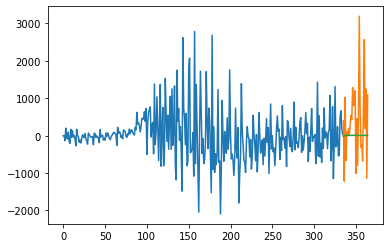

In [21]:
plotser(y_train, y_test, y_forecast)

Предсказание на параметрах 0/1/0 плохо фитит фактическую динамику заражений.

Попробуем найти параметры Arima перебором:

In [22]:
def FindBestAic(p, q, d):
    min_aic = 100000000
    model = None
    for xp in p:
        for xq in q:
            for xd in d:
                try:
                    model_fit = ARIMA(y_train, order=(xp, xq, xd)).fit()
                except:
                    pass
                if min_aic > model_fit.aic:
                    min_aic = model_fit.aic
                    model = (model_fit, xp, xq, xd)
                    print((model_fit.aic, xp, xq, xd))
    return model


In [23]:
model, q, p, d =  FindBestAic(range(0,5), range(0,5), range(0,5))

(5281.586951751369, 0, 0, 0)
(5280.717208244107, 0, 0, 2)
(5264.383148653891, 0, 1, 1)
(5259.090986614103, 0, 1, 2)
(5233.332366057339, 0, 1, 3)
(5231.24549982964, 0, 1, 4)
(953.8776790198582, 1, 4, 4)


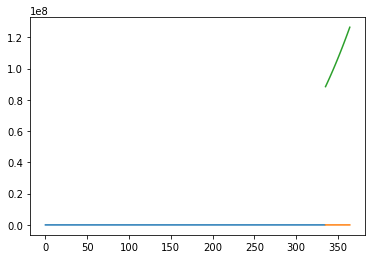

In [24]:
y_forecast = model.forecast(30)
plotser(y_train, y_test, y_forecast)

К сожалению прогноз по-прежнему выглядит не реалистично.

Попробуем вернутся на шаг назад и попробовать построить модель ARIMA на исходных данных, полученных до диференцирования:

In [25]:
Y = rusd['Заражений за день'].values
y_train, y_test = train_test_split(Y, test_size = 30, shuffle = False)

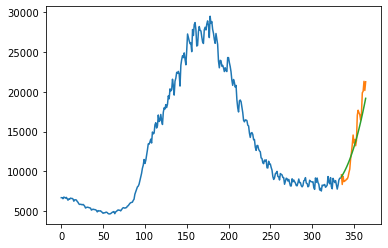

In [26]:
model_fit = ARIMA(y_train, order=(1, 4, 4)).fit()
y_forecast = model_fit.forecast(30)
plotser(y_train, y_test, y_forecast)

Эта подгонка выполнена хорошо. Модель с параметрами 1,4,4 выглядит реалистично.

### Medium
Применим модель градиентного бустинга для предсказания заболеваемости.

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

In [28]:
x = list(range(0, len(y_train)))
xA = np.array(x).reshape(-1, 1)

In [29]:
gboost = GradientBoostingRegressor(max_depth=8)
gboost.fit(xA, y_train)

GradientBoostingRegressor(max_depth=8)

In [30]:
x = list(range(len(y_train), len(y_train) + 30))
xR = np.array(x).reshape(-1, 1)

In [31]:
y_pred = gboost.predict(xR)
y_pred[0:15]

array([9148.0458104, 9148.0458104, 9148.0458104, 9148.0458104,
       9148.0458104, 9148.0458104, 9148.0458104, 9148.0458104,
       9148.0458104, 9148.0458104, 9148.0458104, 9148.0458104,
       9148.0458104, 9148.0458104, 9148.0458104])

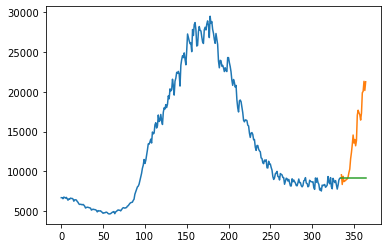

In [32]:
plotser(y_train, y_test, y_pred)

Попробуем создать пошаговый прогноз, смещая шаг на один вперед:

In [33]:
def forecastWindow(yVal, start):
    boost_list = []
    ar_list = []
    for x in range(start, len(yVal)):
        x = list(range(0, x))
        xR = np.array(x)
        print(xR)
        gboost.fit(None, np.array([1,2,3]).reshape(-1,1))
        ar = ARIMA(yVal[0:x], order=(1, 4, 4)).fit()
        #y_boost_val = gboost.predict(np.array(x).reshape(-1, 1))
        #y_arima_val = ar.forecast(1)
        boost_list.append(gboost.predict(np.array(x).reshape(-1, 1)))
        ar_list.append(ar.forecast(1))
    return (boost_list, ar_list)

In [34]:
pred = []
base_pred = []
test = []
x = rusd['Заражений за день'].values
#y_train

In [35]:
pred = []
for i in range(50, len(x)):  
    y_train = x[:i]
    x_train = np.arange(len(y_train)).reshape(-1, 1)
    test.append(x[i])
    model = GradientBoostingRegressor()
    model.fit(x_train, y_train)
    forecast_t = model.predict([[i]])
    pred.append(forecast_t[0]) 
    base_pred.append(x[i-1])

In [36]:
def wforecast(count = 50, useAr=False):
    wpred = []
    wfact = []
    xi = np.arange(count).reshape(-1, 1)
    model = GradientBoostingRegressor()
    for i in range(count, len(Y)-1):
        start = i - count
        y_train = Y[start:i]
        if i - start != count:
            print("size ", len(y_train), " start: ", start, " stop: ", i)
        if len(y_train) != count :
            print("size ", len(y_train), " ", i)
            continue
        if useAr == False:
            model.fit(xi, y_train)
            forecast_val = model.predict([[i]])[0]
            #print(forecast_val[0])
        else:
            ar = ARIMA(y_train, order=(1, 4, 4)).fit()
            forecast_val = ar.forecast(1)[0]
        wfact.append(Y[i])
        wpred.append(forecast_val)
    return (wpred, wfact)

In [37]:
wpred, wfact = wforecast()


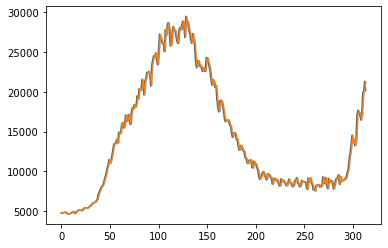

In [38]:
x = list(range(0, len(wpred)))
plt.plot(x, wfact)
plt.plot(x, wpred)

Прогноз следует за фактическими значениями.

Рассмотрим график поближе

In [39]:
def plotSlice(start, stop):
    plt.plot(x[start:stop], wfact[start:stop])
    plt.plot(x[start:stop], wpred[start:stop])

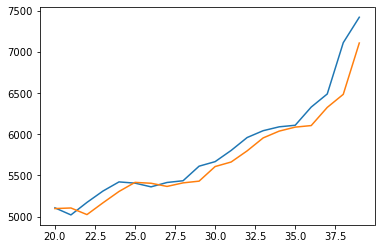

In [40]:
plotSlice(20, 40)

Прогноз повторяет предедущее значение, однако не полностью. Есть различия.

Повторим тоже для arima(1,4,4)

In [41]:
wpred, wfact = wforecast(50, True)

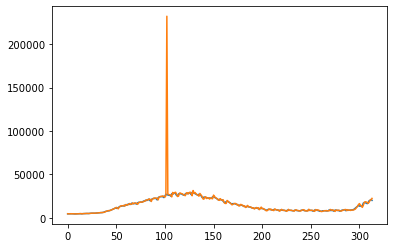

In [42]:
plt.plot(x, wfact)
plt.plot(x, wpred)

Прогноз Arima содержит выброс в районе 102 элемента. Попробуем его заменить на фактического значение и сравнить точность моделей.

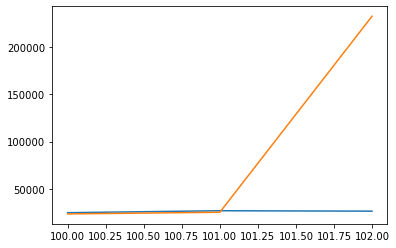

In [43]:
plotSlice(100, 103)

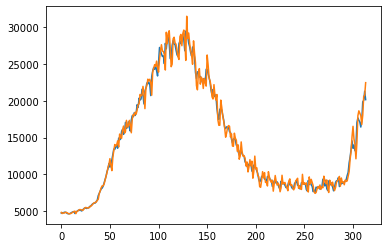

In [44]:
wpred[102] = wfact[102]
plt.plot(x, wfact)
plt.plot(x, wpred)

Прогноз также следует за динамикой фактической заболеваемости.

Попробуем сравнить точность обоих прогнозов

In [45]:
wpred_bst, _ = wforecast()

In [46]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [56]:
dict = {"Точность фитинга бустинга" : r2_score(wfact, wpred_bst),
"Точность фитинга ARIMA" : r2_score(wfact, wpred)} 
dict

{'Точность фитинга бустинга': 0.9898051985731775,
 'Точность фитинга ARIMA': 0.9837712528412512}

Точность фитинга обоих моделей крайне высока и составляет 98%. Но это не говорит о предсказательной силе обоих моделей.

Попробуем оценить точность прогноза знакак приращения для обоих моделей.

In [50]:
bst_df =  np.diff(np.array(wpred_bst))
ar_df =  np.diff(np.array(wpred))
fact_df = np.diff(np.array(wfact))
x = list(range(0, len(bst_df)))

In [51]:
def signeq(x, y):
    sx = np.sign(x)
    sy = np.sign(y)
    if sx == sy:
        return 1
    else:
        return 0

In [52]:
arc = []
bst = []
for x in range(0, len(fact_df)):
    bst.append(signeq(fact_df[x], bst_df[x]))
    arc.append(signeq(fact_df[x], ar_df[x]))

Точность предсказаний знака в % обоих моделей:

In [58]:
dict = {"бустинг" : np.sum(bst) /len(fact_df),
        "ARIMA" : np.sum(arc) /len(fact_df) } 
dict

{'бустинг': 0.5399361022364217, 'ARIMA': 0.5207667731629393}

Точность предсказаний знака обоих моделей близка к случайной, впрочем чуть выше 50%. Из двух моделей бустинг показывает более высокую точность в 54%, против 52% для ARIMA